In [48]:
# importing the zipfile module
from zipfile import ZipFile

# loading the temp.zip and creating a zip object
with ZipFile("sample_cropped.zip", 'r') as zObject:

	# Extracting all the members of the zip
	# into a specific location.
	zObject.extractall(
		path="sample_training")


In [72]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torchvision.io import read_image
import matplotlib.pyplot as plt
from PIL import Image

class CustomImageDataset(Dataset):
  def __init__(self, img_dir, transform=None, target_transform=None):
    #.DS_Store error later with UnidentifiedImageError
    self.img_labels = [f for f in os.listdir(img_dir) if f.lower().endswith(('.png','.jpg','jpeg')) and not f.startswith('.')]
    self.img_dir = img_dir
    # "During training, all images are scaled to 100 x 32 in order to accelerate the training process."
    self.transform = T.Compose([
        T.Resize((32,100)),
        # Input: W x 32 gray-scale image
        T.Grayscale(),
        T.ToTensor()
    ])
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels[idx])


    image = Image.open(img_path)

    label = self.img_labels[idx].split('.')[0].replace('{slash}','/')
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [73]:
customdata = CustomImageDataset("train")

In [74]:
len(customdata)

162

In [75]:
type(customdata.__getitem__(1)[0])

torch.Tensor

In [76]:
customdata.__getitem__(1)[0].size()

torch.Size([1, 32, 100])

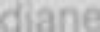

In [77]:
sample_img = customdata.__getitem__(20)[0]
tr = T.ToPILImage()
img = tr(sample_img)
img # not img.show()

In [78]:
customdata.__getitem__(20)[1]

'diane'

https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets


In [82]:
from torch.utils.data.sampler import SubsetRandomSampler

batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed = 42

dataset_size = len(customdata)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [83]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(customdata, batch_size=batch_size, sampler=train_sampler)
test_dataloader = DataLoader(customdata, batch_size=batch_size, sampler=valid_sampler)

In [86]:
for d, l in train_dataloader:
  print(d.size()) # (N, C, H, W)
  print(l)
  break

torch.Size([8, 1, 32, 100])
('British', 'wrox', 'Gt', '150', 'STREET', 'BURNSIDE', 'with', 'Bequet')


In [ ]:
from torch import nn

class CRNN(nn.Module):
  def __init__(self):
    super().__init__()
    # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)
    self.conv1 = nn.Conv2d(1, 64, (3,3),1,1)
    self.maxpool1 = nn.MaxPool2d((2,2),2)
    self.conv2 = nn.Conv2d(64, 128, (3,3), 1, 1)
    self.maxpool2 = nn.MaxPool2d((2,2), 2)
    self.conv3 = nn.Conv2d(128, 256, (3,3), 1, 1)
    self.conv4 = nn.Conv2d(256, 256, (3,3), 1, 1)
    self.maxpool3 = nn.MaxPool2d((1,2), 2)
    self.conv5 = nn.Conv2d(256, 512, (3,3), 1, 1)
    self.bn1 = nn.BatchNorm2d(512)
    self.conv6 = nn.Conv2d(512, 512, (3,3), 1, 1)
    self.bn2 = nn.BatchNorm2d(512)
    self.maxpool4 = nn.MaxPool2d((1,2), 2)

  def forward(self, x):
